# BBM409 Assignment_2

Group Member: Baran Kılıç 2210356108

Group Member: Efe Yiğit Yıldırım 2200356096

## Code

In [46]:
#We are importing the libraries for our assignment here
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix # Metrics
import cv2 # OpenCV
import os
import copy

Since we did our homework on Google Colab, we obtained the data using Google Drive below via Colab. If you also want to test our code on your own computer (without using Colab), set the isColabUsed variable to False and adjust the necessary path below to start reading.







In [47]:
isColabUsed = True
flowers_path = '!!!!!IF isColabUsed = False THEN CHANGE THIS!!!!!'
train_x = []
validation_x = []
test_x = []
train_y = []
validation_y = []
test_y = []

if(isColabUsed):
  from google.colab import drive
  drive.mount('/content/drive')
  flowers_path = '/content/drive/My Drive/flowers'

data_paths = [flowers_path + '/train', flowers_path + '/validation' , flowers_path + '/test']

# i is for deciding on train,validation and test
for i in range(3):
  curr_data_path = data_paths[i]
  for flower_folder in os.listdir(curr_data_path):
    flower_path = os.path.join(curr_data_path, flower_folder)
    for image_file in os.listdir(flower_path):
      image = cv2.resize(cv2.imread(os.path.join(flower_path, image_file)),(100,100))

      histogram_features = cv2.calcHist([image], [0, 1, 2], None, [4, 4, 4], [0, 256, 0, 256, 0, 256]).flatten()
      edges = cv2.Canny(image, 20, 120)
      contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
      total_area = 0
      for contour in contours:
        total_area += cv2.contourArea(contour)

      combined_feature = np.concatenate((np.array([os.path.getsize(os.path.join(flower_path, image_file)),total_area]),histogram_features))

      if i==0:
        train_x.append(combined_feature)
        train_y.append(flower_folder)
      elif i==1:
        validation_x.append(combined_feature)
        validation_y.append(flower_folder)
      else:
        test_x.append(combined_feature)
        test_y.append(flower_folder)

train_x = np.array(train_x)
validation_x = np.array(validation_x)
test_x = np.array(test_x)
train_y = np.array(train_y)
validation_y = np.array(validation_y)
test_y = np.array(test_y)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



First of all, since the data here is already divided into train, validation, and test sets, we didn't need to shuffle or split the data (the order of rows doesn't matter in the ID3 Decision Tree algorithm, so flowers of the same class were read consecutively). We extracted the features we considered important from the data. Among the features we selected, the color histogram was the most significant (we divided each color into 4 parts). After that, we obtained an area calculation using Canny. Surprisingly, the size of the area occupied by the image on the computer also played a crucial role in this assignment (increasing our accuracy values by 5% to 10%). We experimented with all the parameters you see here (such as the parameters for Canny (20-120), the number of pixels the image was read in, the division of the image into 4 for the histogram, etc.) through trial and error to find the combination that maximally increased the accuracy.







After obtaining the features, it was time to obtain the DecisionTree. Let's start by saying this: the DecisionTree algorithm is not compatible with our current normal dataset. However, even though our dataset and the DecisionTree algorithm are not initially compatible, we decided that a binary DecisionTree would be the most suitable structure after extracting the important features of our dataset while still working on the assignment. The goal here is to split each attribute into two using a threshold and find the threshold with the highest information gain. This way, a tree is created. You can see the entire code of the DecisionTree class below.







In [48]:
# It is our node class for decision tree
class Node:
  def __init__(self,feature_index,threshold,info_gain,left,right,value):
    self.feature_index = feature_index
    self.threshold = threshold
    self.info_gain = info_gain
    self.left = left
    self.right = right
    self.value = value #class

# It is our decision tree class
class DecisionTree:
  # Here we are defining our train data
  def __init__(self,train_x,train_y,maxDepth):
    self.maxDepth = maxDepth
    self.root = self.__build_tree(train_x,train_y,list(range(train_x.shape[1])),0)

  # This method calculates class counts in a data and returns it
  @staticmethod
  def __getClassCounts(data_y):
    classCounts  = dict()
    for i in data_y:
      if i in classCounts:
        classCounts[i] += 1
      else:
        classCounts[i] = 1
    return classCounts

  # This method calculates Entropy for a data_y
  @staticmethod
  def __entropy(data_y):
    ent = 0
    lenData = len(data_y)
    if lenData == 0:
      return 0
    classCounts  = DecisionTree.__getClassCounts(data_y)
    values = classCounts.values()
    for i in values:
      prob = i/lenData
      ent -= prob * np.log2(prob)
    return ent

  # This method calculates Information Gain
  @staticmethod
  def __gain(data_x,data_y,feature_index,threshold):

    filter_cond_1 = data_x[:,feature_index] < threshold
    filter_cond_2 = data_x[:,feature_index] >= threshold
    leftChild_y = data_y[filter_cond_1]
    rightChild_y = data_y[filter_cond_2]

    lenData = len(data_y)

    if lenData == 0 or len(leftChild_y) == 0 or len(rightChild_y) == 0:
      return 0

    return DecisionTree.__entropy(data_y) - len(leftChild_y)/lenData * DecisionTree.__entropy(leftChild_y) - len(rightChild_y)/lenData * DecisionTree.__entropy(rightChild_y)

  # This method builds or DecisionTree
  def __build_tree(self,data_x, data_y,attributes,depth):
    classCounts = DecisionTree.__getClassCounts(data_y)
    maxClass = max(classCounts, key=classCounts.get)
    if len(classCounts) == 1 or len(attributes) == 0 or depth >= self.maxDepth:
      return Node(None,None,None,None,None,maxClass)

    feature_index = None
    threshold = None
    best_info_gain = float('-inf')

    for i in attributes:
      # i means feature_index
      thresholds = np.unique(data_x[:, i])
      for j in thresholds:
        gainTemp = DecisionTree.__gain(data_x,data_y,i,j)
        if gainTemp > best_info_gain:
          best_info_gain = gainTemp
          feature_index = i
          threshold = j

    tempNode = Node(feature_index,threshold,best_info_gain,None,None,None)

    filter_cond_1 = data_x[:,feature_index] < threshold
    filter_cond_2 = data_x[:,feature_index] >= threshold
    leftChild_x = data_x[filter_cond_1]
    rightChild_x = data_x[filter_cond_2]
    leftChild_y = data_y[filter_cond_1]
    rightChild_y = data_y[filter_cond_2]

    attributes.remove(feature_index)

    if len(leftChild_x) == 0:
      tempNode.left = Node(None,None,None,None,None,maxClass)
    else:
      tempNode.left = DecisionTree.__build_tree(self,leftChild_x,leftChild_y,copy.copy(attributes) , depth+1)
    if len(rightChild_x) == 0:
      tempNode.right = Node(None,None,None,None,None,maxClass)
    else:
      tempNode.right = DecisionTree.__build_tree(self,rightChild_x,rightChild_y,copy.copy(attributes) , depth+1)
    return tempNode

  @staticmethod
  def predict(node , data_x):
    if node.value is not None:
      return node.value
    if data_x[node.feature_index] < node.threshold:
      return DecisionTree.predict(node.left, data_x)
    else:
      return DecisionTree.predict(node.right, data_x)

  def predictAll(self,data_x):
    result = []
    for i in data_x:
      result.append(DecisionTree.predict(self.root,i))
    return result

  # This function finds twigs
  @staticmethod
  def __find_twigs(node):
    twigs = []
    if node.left is not None and node.right is not None:
      if node.left.left is None and node.left.right is None and node.right.left is None and node.right.right is None:
        twigs.append(node)
      else:
        twigs.extend(DecisionTree.__find_twigs(node.left))
        twigs.extend(DecisionTree.__find_twigs(node.right))
    return twigs

  @staticmethod
  def ___printRules(node,rule):
    if node.value is not None:
      print(rule + "then " + node.value)
    else:
      rule1 = rule + f"feature_{node.feature_index} < {node.threshold} "
      rule2 = rule + f"feature_{node.feature_index} >= {node.threshold} "
      if node.left.value is None:
        rule1 += " and "
      if node.right.value is None:
        rule2 += " and "
      DecisionTree.___printRules(node.left,rule1)
      DecisionTree.___printRules(node.right,rule2)

  def printAllRules(self):
    DecisionTree.___printRules(self.root,"If ")

  def prune_tree(self,validation_x, validation_y):
    last_accuracy = accuracy_score(validation_y,self.predictAll(validation_x))
    while True:
      twigs = DecisionTree.__find_twigs(self.root)
      if len(twigs) == 0:
          break

      lowest_gain_twig = None
      lowest_gain = float('inf')

      for twig in twigs:
        info_gain = twig.info_gain
        if info_gain < lowest_gain:
          lowest_gain = info_gain
          lowest_gain_twig = twig

      templeft = lowest_gain_twig.left
      tempright = lowest_gain_twig.right
      tempfeature = lowest_gain_twig.feature_index
      tempthreshold =   lowest_gain_twig.threshold
      tempInfoGain = lowest_gain_twig.info_gain
      lowest_gain_twig.left = None
      lowest_gain_twig.right = None
      lowest_gain_twig.feature_index = None
      lowest_gain_twig.threshold = None
      lowest_gain_twig.info_gain = None
      current_accuracy = None

      if templeft.value == tempright.value:
        lowest_gain_twig.value = templeft.value
        current_accuracy = accuracy_score(validation_y,self.predictAll(validation_x))
      else:
        #here because of counts of leaves are equal, we took the one which increases accuracy more
        lowest_gain_twig.value = templeft.value
        tempLeftAcc  = accuracy_score(validation_y,self.predictAll(validation_x))
        lowest_gain_twig.value = tempright.value
        current_accuracy  = accuracy_score(validation_y,self.predictAll(validation_x))
        if tempLeftAcc > current_accuracy:
          lowest_gain_twig.value = templeft.value
          current_accuracy = tempLeftAcc

      if current_accuracy >= last_accuracy:
        last_accuracy = current_accuracy
      else:
        lowest_gain_twig.left = templeft
        lowest_gain_twig.right = tempright
        lowest_gain_twig.feature_index = tempfeature
        lowest_gain_twig.threshold = tempthreshold
        lowest_gain_twig.info_gain = tempInfoGain
        lowest_gain_twig.value = None
        break

Now, we will conduct our DecisionTree tests for maxdepth values of 5, 10, 20, and 100. Finally, we will print the rules of the best-performing decision tree variation and then proceed with pruning.

In [49]:
def printResults(tree,test_x,test_y,labels,maxDepth):
  predictions = tree.predictAll(test_x)
  print("Accuracy for maxDepth = " + str(maxDepth) + ": " + str(accuracy_score(test_y,predictions)))
  print("Recall for maxDepth = " + str(maxDepth) + ": " + str(recall_score(test_y,predictions,average="macro")))
  print("Precision for maxDepth = " + str(maxDepth) + ": " + str(precision_score(test_y,predictions,average="macro")))
  print("F1 Score for maxDepth = " + str(maxDepth) + ": " + str(f1_score(test_y,predictions,average="macro")))
  cm = confusion_matrix(test_y, predictions,labels = labels)
  plt.figure(figsize=(4, 4))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
  plt.xlabel('Predicted Labels')
  plt.ylabel('True Labels')
  plt.title('Confusion Matrix for maxDepth = '+ str(maxDepth))
  plt.show()
  print("\n")

Accuracy for maxDepth = 5: 0.536
Recall for maxDepth = 5: 0.5359999999999999
Precision for maxDepth = 5: 0.5654693566583331
F1 Score for maxDepth = 5: 0.5346200476005687


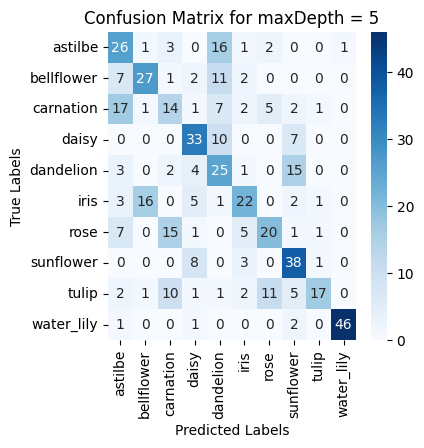



Accuracy for maxDepth = 10: 0.594
Recall for maxDepth = 10: 0.594
Precision for maxDepth = 10: 0.5955725169811326
F1 Score for maxDepth = 10: 0.5908492596619304


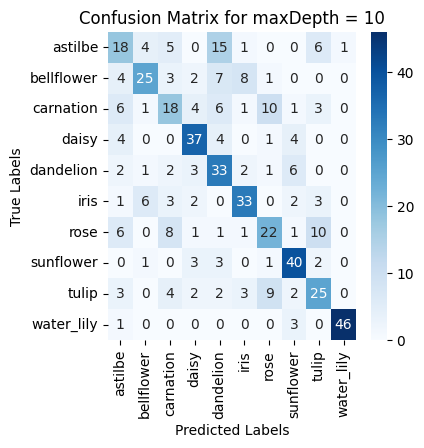



Accuracy for maxDepth = 20: 0.592
Recall for maxDepth = 20: 0.592
Precision for maxDepth = 20: 0.5898937005254238
F1 Score for maxDepth = 20: 0.589189392535131


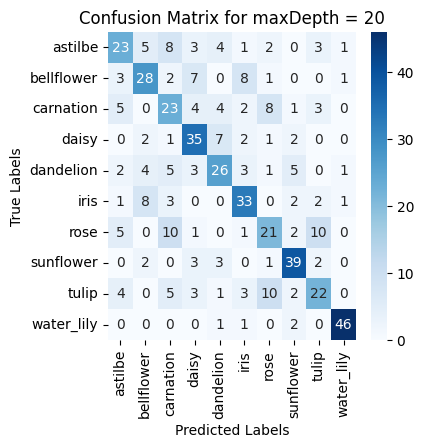



Accuracy for maxDepth = 100: 0.594
Recall for maxDepth = 100: 0.5940000000000001
Precision for maxDepth = 100: 0.591982739737875
F1 Score for maxDepth = 100: 0.5911135075220083


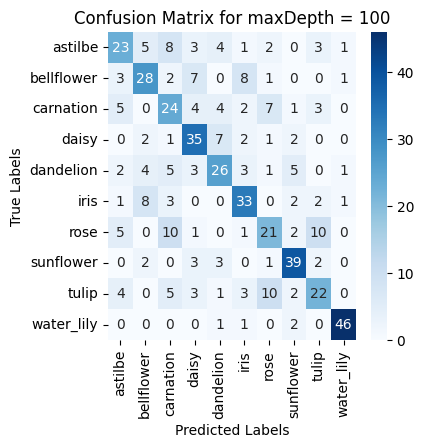

In [50]:
labels = np.unique(test_y)
liste = [5,10,20,100]
treelist = []
for i in liste:
  tree = DecisionTree(train_x,train_y,i)
  treelist.append(tree)
  printResults(tree,test_x,test_y,labels,i)

As we can see from the results, maxDepth = 100 provides the best outcome(maxDepth = 100 and maxDepth = 10 have very similar results but we selected maxDepth = 100 better because of it has higher f1 score and we can see effect of pruning better in that for our report ). Now, let's first print the normal results and rules for maxDepth = 100, and then print the results and rules after pruning.

Accuracy for maxDepth = 100: 0.594
Recall for maxDepth = 100: 0.5940000000000001
Precision for maxDepth = 100: 0.591982739737875
F1 Score for maxDepth = 100: 0.5911135075220083


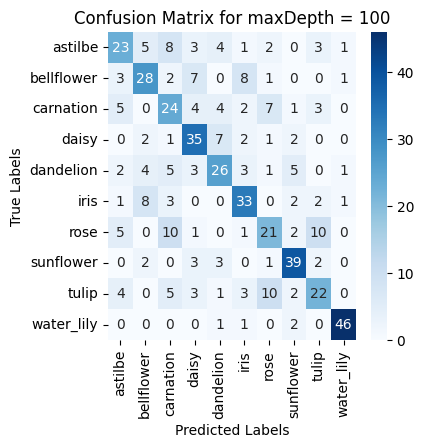

In [51]:
# Normal test results for maxDepth = 100
temp = treelist[3]
printResults(temp,test_x,test_y,labels,100)

In [52]:
# printing rules for normal tree
temp.printAllRules()

If feature_0 < 28122.0  and feature_25 < 3.0  and feature_56 < 1.0  and feature_13 < 6.0  and feature_40 < 18.0  and feature_4 < 31.0  and feature_6 < 52.0  and feature_1 < 273.5  and feature_24 < 19.0  and feature_3 < 1.0  and feature_23 < 462.0  and feature_44 < 6710.0 then bellflower
If feature_0 < 28122.0  and feature_25 < 3.0  and feature_56 < 1.0  and feature_13 < 6.0  and feature_40 < 18.0  and feature_4 < 31.0  and feature_6 < 52.0  and feature_1 < 273.5  and feature_24 < 19.0  and feature_3 < 1.0  and feature_23 < 462.0  and feature_44 >= 6710.0 then carnation
If feature_0 < 28122.0  and feature_25 < 3.0  and feature_56 < 1.0  and feature_13 < 6.0  and feature_40 < 18.0  and feature_4 < 31.0  and feature_6 < 52.0  and feature_1 < 273.5  and feature_24 < 19.0  and feature_3 < 1.0  and feature_23 >= 462.0 then water_lily
If feature_0 < 28122.0  and feature_25 < 3.0  and feature_56 < 1.0  and feature_13 < 6.0  and feature_40 < 18.0  and feature_4 < 31.0  and feature_6 < 52.0  and

Accuracy for maxDepth = 100: 0.6
Recall for maxDepth = 100: 0.6000000000000001
Precision for maxDepth = 100: 0.6027709573473411
F1 Score for maxDepth = 100: 0.5990938752372887


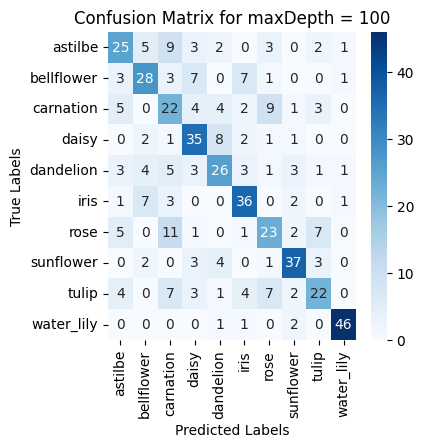

In [53]:
# Test results for prunned tree
temp.prune_tree(validation_x,validation_y)
printResults(temp,test_x,test_y,labels,100)

In [54]:
# printing rules for prunned tree
temp.printAllRules()

If feature_0 < 28122.0  and feature_25 < 3.0  and feature_56 < 1.0  and feature_13 < 6.0  and feature_40 < 18.0  and feature_4 < 31.0  and feature_6 < 52.0  and feature_1 < 273.5  and feature_24 < 19.0  and feature_3 < 1.0  and feature_23 < 462.0  and feature_44 < 6710.0 then bellflower
If feature_0 < 28122.0  and feature_25 < 3.0  and feature_56 < 1.0  and feature_13 < 6.0  and feature_40 < 18.0  and feature_4 < 31.0  and feature_6 < 52.0  and feature_1 < 273.5  and feature_24 < 19.0  and feature_3 < 1.0  and feature_23 < 462.0  and feature_44 >= 6710.0 then carnation
If feature_0 < 28122.0  and feature_25 < 3.0  and feature_56 < 1.0  and feature_13 < 6.0  and feature_40 < 18.0  and feature_4 < 31.0  and feature_6 < 52.0  and feature_1 < 273.5  and feature_24 < 19.0  and feature_3 < 1.0  and feature_23 >= 462.0 then water_lily
If feature_0 < 28122.0  and feature_25 < 3.0  and feature_56 < 1.0  and feature_13 < 6.0  and feature_40 < 18.0  and feature_4 < 31.0  and feature_6 < 52.0  and

## Error Analysis for Classification

Let's first find one misclassified image from "rose" class and comment on why it and other misclassified images are misclassified.

In [55]:
missclass_index = -1
predicted = ""
true_class = "rose"
for i in range(len(test_x)):
  predicted = DecisionTree.predict(temp.root,test_x[i])
  if predicted != test_y[i] and test_y[i] == true_class:
    missclass_index = i
    break
print("Index of missclassfied sample: " + str(missclass_index))
print("Predicted class(missclassfied): " + predicted)

Index of missclassfied sample: 300
Predicted class(missclassfied): iris


Now, let's find a correctly classified rose class item and a correctly classified iris class item.







In [56]:
true_iris = -1
true_rose = -1
for i in range(len(test_x)):
  predicted = DecisionTree.predict(temp.root,test_x[i])
  if predicted == test_y[i] and test_y[i] == "rose" and true_rose == -1:
    true_rose = i
  if predicted == test_y[i] and test_y[i] == "iris" and true_iris == -1:
    true_iris = i
  if true_iris != -1 and true_rose != -1:
    break
print("Index of true classfied rose: " + str(true_rose))
print("Index of true classfied iris: " + str(true_iris))

Index of true classfied rose: 301
Index of true classfied iris: 200


Now, let's find the Euclidean difference between the misclassified index and the correctly classified indices (thus making a comparison). This way, we can gain insight into why it might have been misclassified. This will mean that the misclassified index is closer to the class whose difference is smaller.

In [57]:
ed_true_rose = np.sqrt(np.sum(np.square(np.subtract(test_x[missclass_index], test_x[true_rose]))))
ed_true_iris = np.sqrt(np.sum(np.square(np.subtract(test_x[missclass_index], test_x[true_iris]))))
print("Euclidean difference with true rose: "+ str(ed_true_rose))
print("Euclidean difference with true iris: "+ str(ed_true_iris))

Euclidean difference with true rose: 3618.0919349845162
Euclidean difference with true iris: 3217.7051216666823


As you can see, the difference between our misclassified example (actual class: rose) and the iris example is smaller. The reason for this is the more similar color histograms. Sometimes, flowers can resemble other flower types by deviating from their normal colors. Therefore, we can conclude that it was misclassified (we did not remove backgrounds here, so background similarity could also contribute to the reduced difference. The crucial point is that the reason for misclassification seems to stem from the similarity in color histograms).

Now, let's comment on our Decision Trees. First, let's compare the values of 5, 10, 20, and 100. As can be seen, the difference for 10, 20, and 100 values is very minimal, and all of them provide an average accuracy value of 0.6. Despite the mismatch between our data structure and the algorithm, achieving such a good result is quite pleasing. The reason for a greater difference between 5 and the other values is likely that the value of 5 is causing underfitting, thereby reducing the results. Another point to mention is that the "water_lily" class is classified as the best among all classes for all maxDepth values. This indicates that the "water_lily" class probably has very distinctive data.

Now let's talk about the results of pruning. The pruning process further generalizes a constructed tree (preventing overfitting). As we can understand from our output texts, this process primarily involves removing the right and left children if they are equal and creating a leaf with the same value. In fact, this operation does not have much effect on the tree because the result is the same in any case. The real impact occurs if the right and left children are different. Let's give an example. The original form was

"

If feature_0 < 28122.0  and feature_25 >= 3.0  and feature_5 >= 7.0  and feature_17 < 1.0  and feature_6 >= 109.0  and feature_8 >= 16.0  and feature_19 < 106.0  and feature_1 < 2220.5  and feature_7 >= 96.0  and feature_44 < 1071.0  and feature_49 >= 71.0  and feature_13 >= 1.0  and feature_2 >= 559.0  and feature_29 < 374.0  and feature_9 < 579.0  and feature_31 < 1.0  and feature_11 >= 81.0  and feature_48 < 315.0 then tulip

If feature_0 < 28122.0  and feature_25 >= 3.0  and feature_5 >= 7.0  and feature_17 < 1.0  and feature_6 >= 109.0  and feature_8 >= 16.0  and feature_19 < 106.0  and feature_1 < 2220.5  and feature_7 >= 96.0  and feature_44 < 1071.0  and feature_49 >= 71.0  and feature_13 >= 1.0  and feature_2 >= 559.0  and feature_29 < 374.0  and feature_9 < 579.0  and feature_31 < 1.0  and feature_11 >= 81.0  and feature_48 >= 315.0 then rose

"

and it has transformed into

"

If feature_0 < 28122.0  and feature_25 >= 3.0  and feature_5 >= 7.0  and feature_17 < 1.0  and feature_6 >= 109.0  and feature_8 >= 16.0  and feature_19 < 106.0  and feature_1 < 2220.5  and feature_7 >= 96.0  and feature_44 < 1071.0  and feature_49 >= 71.0  and feature_13 >= 1.0  and feature_2 >= 559.0  and feature_29 < 374.0  and feature_9 < 579.0  and feature_31 < 1.0  and feature_11 >= 81.0 then tulip

"

This has increased our accuracy value from 0.594 to 0.6. The main reason for this is, as mentioned earlier, the generalization of the tree(So the reason for why the attribute is prunned is the process of generalization). So we prevented our tree from overfitting and increased our accuracy value.
